# Assignment 03
The datasets contains IPL player's auction prices (base price and sold price) and relevant details of each player. 

    1) Fit a linear regression model to predict the sold-price of the player. 
    2) Use variable reduction techniques covered so far to identify significant variables.
    3) What is the RMSE of the model?
    4) What are the top 5 variables that impact the price of the player. 

Make appropriate assumptions as necessary for solving the assignment. 
Note that this data may not match actual player data . 


# Answers
1. Linear regression model, after removing variables based on p-value and VIF, is as below:
    
    4.887e+04 + 5528.6978 * SIXERS + 1.3959 * Base_Price + 1.302e+05 * INDIA + 1.302e+05 * Country_IND  

The R-square of the model is 50.6%, which is on lower side and does not mean that we have a great fit. Perhaps we should model sperately fro Batsman and Bowler, and keeping allrounders with Batsman. This should improve the model, since model fitting is increasing biased towards batsman, owing to higher number of batsman in the data and higher price for batsman.

2. Following variable reduction techniques being used, with final variables
    - Forward selection using mlxtend
            - 'SIXERS', 'Base_Price', 'INDIA'
    - Backward selection using mlxtend
            - 'SIXERS', 'Base_Price', 'Country_IND'
    - Ridge(only top 5)
            - 'CAPTAINCY_EXP', 'INDIA', 'Country_IND', 'BAT_RUN_S', 'OTHERS'
    - Lasso(only top 5)
            - 'Base_Price', 'SIXERS', 'INDIA', 'CAPTAINCY_EXP', 'BAT_RUN_S'
    - Elastic-Net(only top 5)
            - 'Base_Price', 'SIXERS', 'INDIA', 'CAPTAINCY_EXP', 'BAT_RUN_S'

3. RMSE of various models as below:<br>

| Modelling Technique                       | RMSE     |
--------------------------------------------|----------|
| Linear Regression                         | 2,84,900 |
| Forward selecion with Linear Regression   | 2,84,900 |
| Backward selection with Linear Regression | 2,84,900 |
| Ridge Regression                          | 2,92,862 |
| Lasso Regression                          | 2,81,617 |
| Elastic Net Regression                    | 2,95,638 |

4. Mentioned in 2

In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Importing the datasets
df = pd.read_csv('Assignment 03-IPL_Case_data.csv')

df = df.loc[df['Country'].notna()]
df.head(1)

,PLAYER NAME,Country,Team,PLAYING ROLE,BAT,BOW,ALL,BAT-StrikeRate,BOW-Economy,BOW*SR-BL,BAT*RUN-S,BOW*WK-I,BAT*T-RUNS,BAT*ODI-RUNS,BOW*WK-O,Total-RUNS,Total-WKTS,ODI-RUNS,ODI-SR-B,ODI-WKTS,ODI-SR-BL,CAPTAINCY EXP,INDIA,AUSTRALIA,OTHERS,Highest Score,AVERAGE RUNS,SR -B,SIXERS,AVE-BL,ECON,SR -BL,Year,Year_Dummy,Base_Price,SoldPrice
0,"Abdulla, YA",SA,KXIP,Allrounder,0.0,0.0,1.0,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-,-,-,20.47,8.90,13.93,2009.0,0.0,50000.0,50000.0


In [3]:
#df.info()

In [4]:
# re.sub('[^0-9a-zA-Z]+', '_', 
new_col_names = [re.sub('[^0-9a-zA-Z]+', '_', s.strip()) for s in df.columns]
df.columns = new_col_names
df.columns

Index(['PLAYER_NAME', 'Country', 'Team', 'PLAYING_ROLE', 'BAT', 'BOW', 'ALL',
       'BAT_StrikeRate', 'BOW_Economy', 'BOW_SR_BL', 'BAT_RUN_S', 'BOW_WK_I',
       'BAT_T_RUNS', 'BAT_ODI_RUNS', 'BOW_WK_O', 'Total_RUNS', 'Total_WKTS',
       'ODI_RUNS', 'ODI_SR_B', 'ODI_WKTS', 'ODI_SR_BL', 'CAPTAINCY_EXP',
       'INDIA', 'AUSTRALIA', 'OTHERS', 'Highest_Score', 'AVERAGE_RUNS', 'SR_B',
       'SIXERS', 'AVE_BL', 'ECON', 'SR_BL', 'Year', 'Year_Dummy', 'Base_Price',
       'SoldPrice'],
      dtype='object')

In [5]:
#df.info()
df['PLAYING_ROLE'].value_counts()
#df['BOW'].value_counts()

Batsman       51
Bowler        44
Allrounder    35
Name: PLAYING_ROLE, dtype: int64

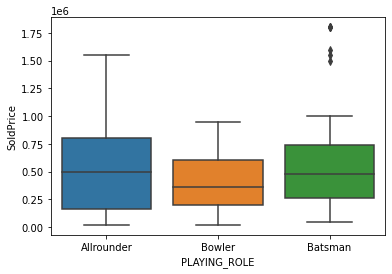

In [6]:
sns.boxplot(x='PLAYING_ROLE', y='SoldPrice', data=df)
plt.show()

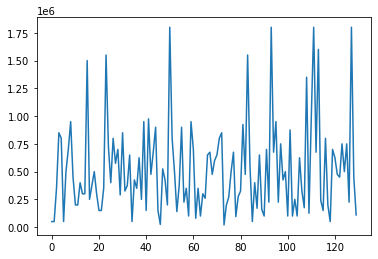

In [7]:
plt.plot(df['SoldPrice'])

In [8]:
# some batsman have very high outliers
# from the above plot, any rows with Sold Price > 125 * 10^6, should be treated as outliers
df.loc[df['SoldPrice'] >= 1.25 * 10**6].shape # removes 9 observation from data
df.loc[df['SoldPrice'] >= 1.25 * 10**6]['PLAYING_ROLE'].value_counts() # with seven batsman and 2 bowlers
#df = df.loc[df['SoldPrice'] <= 1.25 * 10**6]
#df.shape

Batsman       7
Allrounder    2
Name: PLAYING_ROLE, dtype: int64

## 1. Fit a linear regression model to predict the sold-price of the player.

In [9]:
#df.head(1)
# df.describe()

In [10]:
cat_vars = ['Country', 'Team', 'PLAYING_ROLE']
dummy_vars = ['BAT', 'BOW', 'ALL', 'CAPTAINCY_EXP',  'INDIA', 'AUSTRALIA', 'OTHERS']
num_vars = [ 'BAT_StrikeRate', 'BOW_Economy', 'BOW_SR_BL', 'BAT_RUN_S', 'BOW_WK_I',
             'BAT_T_RUNS', 'BAT_ODI_RUNS', 'BOW_WK_O', 'Total_RUNS', 'Total_WKTS',
             'ODI_RUNS', 'ODI_SR_B', 'ODI_WKTS', 'ODI_SR_BL', 'Highest_Score', 'AVERAGE_RUNS', 'SR_B',
             'SIXERS', 'AVE_BL', 'ECON', 'SR_BL', 'Base_Price'
           ]
y_var = 'SoldPrice'

In [11]:
# year and year_dummy not making sense, hence drop these variables from model fitting process
pd.crosstab(df['Year_Dummy'], df['Year'])

Year,2008.0,2009.0,2010.0,2011.0
Year_Dummy,,,,
0.0,75,10,3,0
1.0,0,0,0,42


In [12]:
df_dummy = pd.get_dummies(df, 
                          columns=cat_vars, 
                          drop_first=True
                         )

In [13]:
dummay_vars_2 = ['Country_BAN', 'Country_ENG', 'Country_IND', 'Country_NZ',
                 'Country_PAK', 'Country_SA', 'Country_SL', 'Country_WI', 'Country_ZIM',
                 'Team_CSK+', 'Team_DC', 'Team_DC+', 'Team_DD', 'Team_DD+', 'Team_KKR',
                 'Team_KKR+', 'Team_KXI+', 'Team_KXIP', 'Team_KXIP+', 'Team_MI',
                 'Team_MI+', 'Team_RCB', 'Team_RCB+', 'Team_RR', 'Team_RR+',
                 'PLAYING_ROLE_Batsman', 'PLAYING_ROLE_Bowler'
                ]

In [14]:
# convert to numeric and make null as zero
vrb_list = ['BAT_StrikeRate', 'BOW_Economy', 'BOW_SR_BL', 'AVERAGE_RUNS', 'SR_B', 
            'SIXERS', 'AVE_BL', 'ECON', 'SR_BL']
for vrb in vrb_list:
    df_dummy[vrb] = pd.to_numeric(df_dummy[vrb], errors='coerce').fillna(0)

In [15]:
# Vif analysis to understand variables fit for modelling
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_var = ['BAT_StrikeRate', 'BOW_Economy', 'BOW_SR_BL', 'BAT_RUN_S', 'BOW_WK_I',
         'BAT_T_RUNS', 'BAT_ODI_RUNS', 'BOW_WK_O', 'Total_RUNS', 'Total_WKTS',
         'ODI_RUNS', 'ODI_SR_B', 'ODI_WKTS', 'ODI_SR_BL', 'Highest_Score', 'AVERAGE_RUNS', 'SR_B',
         'SIXERS', 'AVE_BL', 'ECON', 'SR_BL', 'Base_Price'
        ]
cut_off = 5
max_VIF = 100
# remove variable with highest VIF and repeat till all variables, have VIF less than cut-off
while max_VIF > cut_off:
    X = df_dummy[num_var]
    vif_series = pd.Series([variance_inflation_factor(X.values, i) 
                           for i in range(X.shape[1])], index=X.columns)
    max_VIF = vif_series.sort_values(ascending=False)[0]
    if max_VIF > cut_off:
        rem_var = vif_series.sort_values(ascending=False).index[0]
        num_var.remove(rem_var)
        print(f"Variable {rem_var} removed with VIF {max_VIF}")

Variable SR_BL removed with VIF 90.42207714714452
Variable BAT_T_RUNS removed with VIF 47.0143015422008
Variable ODI_RUNS removed with VIF 23.636473786734285
Variable AVERAGE_RUNS removed with VIF 23.54775117754775
Variable SR_B removed with VIF 14.160961615709862
Variable Highest_Score removed with VIF 12.002317065811035
Variable BOW_Economy removed with VIF 10.750629825102658
Variable ODI_SR_B removed with VIF 8.781601268035146
Variable AVE_BL removed with VIF 7.730528094178624
Variable ODI_WKTS removed with VIF 7.365987365403608
Variable BAT_ODI_RUNS removed with VIF 6.687286989078427


In [16]:
num_var

['BAT_StrikeRate',
 'BOW_SR_BL',
 'BAT_RUN_S',
 'BOW_WK_I',
 'BOW_WK_O',
 'Total_RUNS',
 'Total_WKTS',
 'ODI_SR_BL',
 'SIXERS',
 'ECON',
 'Base_Price']

In [17]:
def fit_lin_reg_with_intercept(X, Y):
    X = sm.add_constant(X) # adding a constant
    reg_model = sm.OLS(Y,X).fit()
    return reg_model

In [18]:
def remove_variables_with_highest_p_value(df, x_vars, y_var, p_value_cut_off = 0.05):
    p_value_max = 1
    while p_value_max > p_value_cut_off:
        reg_model  = fit_lin_reg_with_intercept(df[x_vars], df[y_var])
        p_values = reg_model.pvalues
        size = p_values.size
        p_values = p_values[1:size] # remove intercept 
        p_value_max = p_values.sort_values(ascending=False)[0]
        if p_value_max > p_value_cut_off:
            rem_var = p_values.sort_values(ascending=False).index[0]
            x_vars.remove(rem_var)
            print(f"Variable {rem_var} removed with p-value {p_value_max}")
    
    return x_vars

In [19]:
x_vars = num_var + dummy_vars + dummay_vars_2
y_var = 'SoldPrice'

In [20]:
vars_to_model = remove_variables_with_highest_p_value(df_dummy, x_vars, y_var)

Variable ODI_SR_BL removed with p-value 0.9983848611739636
Variable AUSTRALIA removed with p-value 0.9337367747504021
Variable Country_ZIM removed with p-value 0.928771585656146
Variable Country_PAK removed with p-value 0.9816002461588875
Variable BAT_StrikeRate removed with p-value 0.8841486069203912
Variable Team_KKR+ removed with p-value 0.8847384041211804
Variable Team_DC+ removed with p-value 0.8951884819434713
Variable Team_KKR removed with p-value 0.8000971903699368
Variable Total_WKTS removed with p-value 0.8100677194195599
Variable Country_SL removed with p-value 0.739376068828234
Variable Team_DD+ removed with p-value 0.7042250698344237
Variable Country_BAN removed with p-value 0.685576442010502
Variable PLAYING_ROLE_Bowler removed with p-value 0.7140139526789009
Variable BOW removed with p-value 0.7140139525511702
Variable ALL removed with p-value 0.921237173866591
Variable Team_MI+ removed with p-value 0.63679432588598
Variable Team_CSK+ removed with p-value 0.5798606921664

In [21]:
reg_model = fit_lin_reg_with_intercept(df_dummy[vars_to_model], df_dummy[y_var])
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     42.97
Date:                Sun, 29 May 2022   Prob (F-statistic):           3.38e-19
Time:                        22:40:42   Log-Likelihood:                -1817.2
No. Observations:                 130   AIC:                             3642.
Df Residuals:                     126   BIC:                             3654.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.887e+04   4.99e+04      0.980      

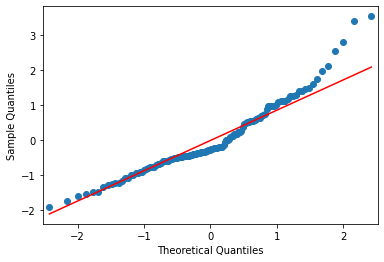

In [22]:
residuals = reg_model.resid 
sm.qqplot(residuals, fit=True, line="q")
plt.show()

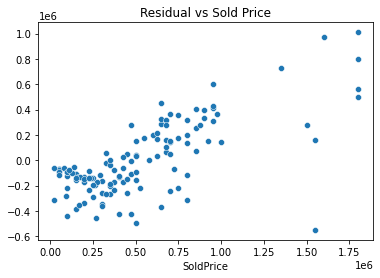

In [23]:
# Residual plot 
#residuals = reg_model.resid 
fig = sns.scatterplot(x=df_dummy[y_var], y=residuals)
fig.set_title("Residual vs Sold Price")
plt.show()

In [24]:
# RMSE
y_predicted = reg_model.fittedvalues
rmse_lr = mean_squared_error(df_dummy[y_var], y_predicted, squared=False)
rmse_lr

284900.0018466439

### 1
Linear regression model, after removing variables based on p-value and VIF, is as below:
    
    4.887e+04 + 5528.6978 * SIXERS + 1.3959 * Base_Price + 1.302e+05 * INDIA + 1.302e+05 * Country_IND  

The R-square of the model is 50.6%, which is on lower side and does not mean that we have a great fit. Perhaps we should model sperately fro Batsman and Bowler, and keeping allrounders with Batsman. This should improve the model, since model fitting is increasing biased towards batsman, owing to higher number of batsman in the data and higher price for batsman.

## Variable Reduction techniques

### Forward and Backward selection using mlxtend

#### Forward selection

In [25]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [26]:
x_vars = num_var + dummy_vars + dummay_vars_2
y_var = 'SoldPrice'
sfs_forward = sfs(lr,
                  k_features=3,
                  forward=True,
                  floating=False,
                  scoring='neg_mean_squared_error',
                  cv=10
                 )

sfs_forward = sfs_forward.fit(df_dummy[x_vars], df_dummy[y_var])
print('Best subset:', sfs_forward.k_feature_names_)

Best subset: ('SIXERS', 'Base_Price', 'INDIA')


In [27]:
reg_model = fit_lin_reg_with_intercept(df_dummy[list(sfs_forward.k_feature_names_)], df_dummy[y_var])
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     42.97
Date:                Sun, 29 May 2022   Prob (F-statistic):           3.38e-19
Time:                        22:40:48   Log-Likelihood:                -1817.2
No. Observations:                 130   AIC:                             3642.
Df Residuals:                     126   BIC:                             3654.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.887e+04   4.99e+04      0.980      0.3

In [28]:
y_predicted = reg_model.fittedvalues
rmse_lr_fs = mean_squared_error(df_dummy[y_var], y_predicted, squared=False)
rmse_lr_fs

284900.001846644

With forward selection, we have to settle with 3 variables, since with higher variables, we are getting insignificant variables

#### Backward selection

In [29]:
sfs_back = sfs(lr,
            k_features=3,
            forward=False,
            floating=False,
            scoring='neg_mean_squared_error',
            cv=10)

sfs_back = sfs_back.fit(df_dummy[x_vars], df_dummy[y_var])
print('Best subset:', sfs_back.k_feature_names_)

Best subset: ('SIXERS', 'Base_Price', 'Country_IND')


In [30]:
reg_model = fit_lin_reg_with_intercept(df_dummy[list(sfs_back.k_feature_names_)], df_dummy[y_var])
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     42.97
Date:                Sun, 29 May 2022   Prob (F-statistic):           3.38e-19
Time:                        22:41:27   Log-Likelihood:                -1817.2
No. Observations:                 130   AIC:                             3642.
Df Residuals:                     126   BIC:                             3654.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.887e+04   4.99e+04      0.980      

In [31]:
y_predicted = reg_model.fittedvalues
rmse_lr_bs = mean_squared_error(df_dummy[y_var], y_predicted, squared=False)
rmse_lr_bs

284900.001846644

In [32]:
# Standardize data, so as to compare coefficients, which are compareable
df_x = df_dummy[x_vars].copy()
target = df_dummy[y_var]
df_x = (df_x - df_x.min()) / (df_x.max() - df_x.min())

### Ridge regression

Steps to identify best alpha
   - Vary alpha from 0.01 to 1

In [33]:
alpha_range = np.arange(.01, 0.1, 0.01).tolist() + np.arange(.1, 1, 0.1).tolist() + np.arange(1, 100, 1).tolist() + \
              np.arange(100, 10000, 100).tolist()
# define model
model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = alpha_range
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(df_x, target)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -282842.178
Config: {'alpha': 4}


In [34]:
ri_model = Ridge(alpha=results.best_params_['alpha'])
ri_model.fit(df_x, target)
#ri_model.coef_
df_ridge_coeff = pd.DataFrame({'variable_name' : df_x.columns, 'coeff_value' : np.abs(ri_model.coef_)})
vrb_top_5 = df_ridge_coeff.sort_values(by = 'coeff_value', ascending=False)['variable_name'][0:5]
vrb_top_5
#df_ridge_coeff.sort_values(by = 'coeff_value', ascending=False)

10       Base_Price
8            SIXERS
2         BAT_RUN_S
14    CAPTAINCY_EXP
19      Country_ENG
Name: variable_name, dtype: object

In [35]:
y_predicted = ri_model.predict(df_x)
rmse_lr_enm = mean_squared_error(df_dummy[y_var], y_predicted, squared=False)
rmse_lr_enm

292862.5834338793

### Lasso regression

In [36]:
alpha_range = np.arange(.01, 0.1, 0.01).tolist() + np.arange(.1, 1, 0.1).tolist() + np.arange(1, 100, 1).tolist() + \
              np.arange(100, 10000, 100).tolist()
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = alpha_range
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(df_x, target)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -248544.574
Config: {'alpha': 5700}


In [37]:
lasso_model = Lasso(alpha=results.best_params_['alpha'])
lasso_model.fit(df_x, target)
#ri_model.coef_
df_lasso_coeff = pd.DataFrame({'variable_name' : df_x.columns, 'coeff_value' : np.abs(lasso_model.coef_)})
vrb_top_5 = df_lasso_coeff.sort_values(by = 'coeff_value', ascending=False)['variable_name'][0:5]
vrb_top_5

10       Base_Price
8            SIXERS
15            INDIA
14    CAPTAINCY_EXP
2         BAT_RUN_S
Name: variable_name, dtype: object

In [38]:
y_predicted = lasso_model.predict(df_x)
rmse_lr_enm = mean_squared_error(df_dummy[y_var], y_predicted, squared=False)
rmse_lr_enm

281617.0843639907

### Elastic Net

In [39]:
alpha_range = np.arange(.01, 0.1, 0.01).tolist() + np.arange(.1, 1, 0.1).tolist() + np.arange(1, 100, 1).tolist() + \
              np.arange(100, 10000, 100).tolist()
l1_ratio_range = np.arange(.01, 0.1, 0.01).tolist() + np.arange(.1, 1, 0.1).tolist() 
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = alpha_range
grid['l1_ratio'] = l1_ratio_range
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(df_x, target)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -282850.935
Config: {'alpha': 0.06999999999999999, 'l1_ratio': 0.5}


In [40]:
ElasticNet_model = ElasticNet(alpha=results.best_params_['alpha'], l1_ratio=results.best_params_['l1_ratio'])
ElasticNet_model.fit(df_x, target)
#ri_model.coef_
df_elastic_net_coeff = pd.DataFrame({'variable_name' : df_x.columns, 'coeff_value' : np.abs(lasso_model.coef_)})
df_elastic_net_coeff.sort_values(by = 'coeff_value', ascending=False)['variable_name'][0:5]

10       Base_Price
8            SIXERS
15            INDIA
14    CAPTAINCY_EXP
2         BAT_RUN_S
Name: variable_name, dtype: object

In [41]:
y_predicted = ElasticNet_model.predict(df_x)
rmse_lr_enm = mean_squared_error(df_dummy[y_var], y_predicted, squared=False)
rmse_lr_enm

295638.6737038106